In [3]:
import pickle
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from sentence_transformers import SentenceTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [4]:
# import data
twitter_file = "data/Tweets.csv"
df = pd.read_csv(twitter_file).dropna()
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [5]:
# Create Target Variable
cat_id = {"neutral": 1, "negative": 0, "positive": 2}

df["class"] = df["sentiment"].map(cat_id)

In [6]:
# Hyperparameters
BATCH_SIZE = 128
NUM_EPOCHS = 80
MAX_FEATURES = 10

In [7]:
# Embedding Model
emb_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v1")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/9.90k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/591 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [8]:
sentences = ["Each sentence is converted"]
embeddings = emb_model.encode(sentences)
print(embeddings.squeeze().shape)

(768,)


In [9]:
# prepare X and y
X = emb_model.encode(df["text"].values)

# with open("data/tweets_X.pkl", "wb") as output_file:
#     pickle.dump(X, output_file)

# with open("data/tweets_X.pkl", "rb") as input_file:
#     X = pickle.load(input_file)

y = df["class"].values

In [10]:
# Train Val Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=123
)

In [11]:
class SentimentData(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y).type(torch.LongTensor)
        self.len = len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len

In [12]:
train_ds = SentimentData(X=X_train, y=y_train)
test_ds = SentimentData(X_test, y_test)

# Dataloader
train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=15000)

In [13]:
# Model
class SentimentModel(nn.Module):
    def __init__(self, NUM_FEATURES, NUM_CLASSES, HIDDEN=10):
        super().__init__()
        self.linear = nn.Linear(NUM_FEATURES, HIDDEN)
        self.linear2 = nn.Linear(HIDDEN, NUM_CLASSES)
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.log_softmax(x)
        return x

In [14]:
# Model, Loss and Optimizer
model = SentimentModel(NUM_FEATURES=X_train.shape[1], NUM_CLASSES=3)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

In [15]:
# Model Training
train_losses = []
for e in range(NUM_EPOCHS):
    curr_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred_log = model(X_batch)
        loss = criterion(y_pred_log, y_batch.long())

        curr_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_losses.append(curr_loss)
    print(f"Epoch {e}, Loss: {curr_loss}")

Epoch 0, Loss: 112.94130641222
Epoch 1, Loss: 92.96271347999573
Epoch 2, Loss: 82.83617806434631
Epoch 3, Loss: 78.86971151828766
Epoch 4, Loss: 76.96221268177032
Epoch 5, Loss: 75.68104201555252
Epoch 6, Loss: 74.72305887937546
Epoch 7, Loss: 73.88778591156006
Epoch 8, Loss: 73.11597687005997
Epoch 9, Loss: 72.55027145147324
Epoch 10, Loss: 71.99795120954514
Epoch 11, Loss: 71.50743299722672
Epoch 12, Loss: 70.96452111005783
Epoch 13, Loss: 70.49769300222397
Epoch 14, Loss: 70.0057355761528
Epoch 15, Loss: 69.77030691504478
Epoch 16, Loss: 69.2876289486885
Epoch 17, Loss: 68.85364112257957
Epoch 18, Loss: 68.70122456550598
Epoch 19, Loss: 68.28851783275604
Epoch 20, Loss: 67.95237305760384
Epoch 21, Loss: 67.58456403017044
Epoch 22, Loss: 67.2860517501831
Epoch 23, Loss: 67.08542838692665
Epoch 24, Loss: 66.69530910253525
Epoch 25, Loss: 66.46348875761032
Epoch 26, Loss: 66.17388752102852
Epoch 27, Loss: 66.02059596776962
Epoch 28, Loss: 65.75311148166656
Epoch 29, Loss: 65.5467354953

<Axes: >

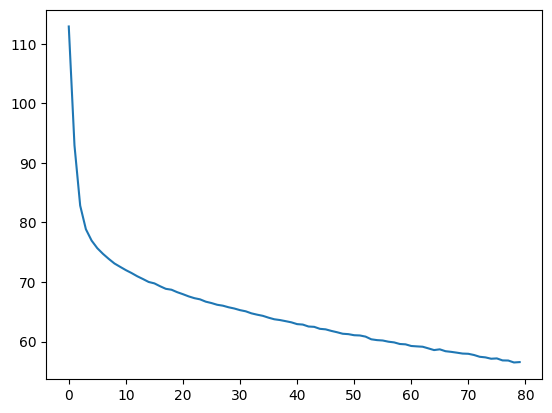

In [16]:
sns.lineplot(x=list(range(len(train_losses))), y=train_losses)

In [17]:
# Model Evaluation
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_test_pred_log = model(X_batch)
        y_test_pred = torch.argmax(y_test_pred_log, dim=1)

In [18]:
y_test_pred_np = y_test_pred.squeeze().cpu().numpy()

acc = accuracy_score(y_pred=y_test_pred_np, y_true=y_test)
f"The accuracy of the model is {np.round(acc, 3)*100}%."

'The accuracy of the model is 67.7%.'

In [19]:
most_common_cnt = Counter(y_test).most_common()[0][1]
print(f"Naive Classifier: {np.round(most_common_cnt / len(y_test) * 100, 1)} %")

Naive Classifier: 41.0 %
